In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import cv2
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score
import segmentation_models_pytorch as smp

folder_path = "PTUMOUSE"

seed_value = 52
torch.manual_seed(seed_value)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [50]:
train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [51]:
def calculate_iou(predictions, targets):
    total_sum = 0.0
    for prediction, target in zip(predictions, targets):
        intersection = np.logical_and(prediction, target).sum().item()
        union = np.logical_or(prediction, target).sum().item()
        
        total_sum += intersection / union if union > 0 else 0.0

    return total_sum / len(predictions)

In [52]:
def ap_k(predictions, targets, k, klass):
    precision = 0
    tp = 0
    all_det = 0
    for i in range(k):
        predict = predictions[i]
        target = targets[i]

        if klass:
            tp += np.sum(predict[predict == target])
            all_det += np.sum(predict)
            precision += tp / all_det
        else:
            tp += len(predict[predict == target]) - np.count_nonzero(predict[predict == target])
            all_det += predict.size - np.count_nonzero(predict)
            precision += tp / all_det
    return precision / k 

def compute_ap(predictions, targets, k):
    return (ap_k(predictions, targets, k, True) + ap_k(predictions, targets, k, False)) / 2, ap_k(predictions, targets, k, True)



In [53]:
def compute_precision_recall(predicted_masks, ground_truth_masks):
    predicted_masks_flat = predicted_masks.flatten()
    ground_truth_masks_flat = ground_truth_masks.flatten()
    precision = precision_score(ground_truth_masks_flat, predicted_masks_flat)
    recall = recall_score(ground_truth_masks_flat, predicted_masks_flat)
    return precision, recall

### Preprocessing (подготовка данных)

In [54]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]
        orig_image = Image.open(orig_image_path).convert('RGB')
        mask_image = Image.open(mask_image_path).convert('L')
        
        orig_image = self.transform_image(orig_image)
        orig_image = orig_image.to(orig_image)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)
        
        return orig_image.float(), mask_image.float()

In [55]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (288, 288)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 8

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [56]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion, model_name, scheduler=None):
  train_losses = []
  val_losses = []
  iou_test = []
  max_iou = 0.0

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))
    
    if scheduler is not None:
      scheduler.step(loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    predictions, _, orig_masks, _ = prediction(model, test_loader)
    iou = calculate_iou(predictions, orig_masks)
    iou_test.append(iou)

    if iou > max_iou and iou > 0.87:
       max_iou = iou
       torch.save(model.state_dict(), f"models/{model_name}_IOU-{iou}.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, IOU: {iou:.4f}")
  return model, train_losses, val_losses, iou_test

### Prediction function

In [57]:
def prediction(model, loader):
    model.eval()
    predictions = []
    orig_images = []
    orig_masks = []
    intersection_masks = []
    size = (576, 544)
    transform = transforms.Compose([transforms.Resize(size)])
    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            new_outputs = torch.zeros(outputs.shape[0], outputs.shape[1], outputs.shape[2], outputs.shape[3])
            outputs[outputs < 0] = 0
            outputs[outputs > 0] = 1

            outputs = transform(outputs)
            x_batch = transform(x_batch)
            y_batch = transform(y_batch)

            outputs = torch.round(outputs)
            y_batch = torch.round(y_batch)

            predictions.append(outputs.cpu().numpy())
            orig_images.append(x_batch.cpu().numpy())
            orig_masks.append(y_batch.cpu().numpy())

            intersection = np.abs(outputs.cpu().numpy() - y_batch.cpu().numpy())
            intersection_masks.append(intersection)
    predictions = np.concatenate(predictions, axis=0).squeeze()
    orig_images = np.concatenate(orig_images, axis=0).squeeze()
    orig_masks = np.concatenate(orig_masks, axis=0).squeeze()
    intersection_masks = np.concatenate(intersection_masks, axis=0).squeeze()
    return predictions, orig_images, orig_masks, intersection_masks

In [92]:
def validation(model, loader):
    predictions, orig_images, orig_masks, intersection_masks = prediction(model, loader)

    iou = calculate_iou(predictions, orig_masks)
    apk, ap = compute_ap(predictions, orig_masks, len(predictions))
    precision, recall = compute_precision_recall(predictions, orig_masks)
    print(f"IOU: {iou}")
    print(f"Precision: {precision}, Recall: {recall}")

### Experiments

In [59]:
model_name = 'efficientnet-b3'
model = smp.UnetPlusPlus(encoder_name=model_name, encoder_weights='imagenet', in_channels=3, classes=1)
model.to(device)


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

In [60]:
import segmentation_models_pytorch as smp

learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
criterion = smp.losses.DiceLoss(mode='binary')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [61]:
num_epochs = 30 
model, train_losses, val_losses, iou_test = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion, model_name, scheduler)

100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch [1/30], Train loss: 93.5874, Val loss: 2.7864, IOU: 0.8347


100%|██████████| 2/2 [00:00<00:00, 17.16it/s]


Epoch [2/30], Train loss: 21.0305, Val loss: 2.0985, IOU: 0.8502


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [3/30], Train loss: 18.0109, Val loss: 1.9105, IOU: 0.8497


100%|██████████| 2/2 [00:00<00:00, 16.08it/s]


Epoch [4/30], Train loss: 16.7122, Val loss: 1.9138, IOU: 0.8488


100%|██████████| 2/2 [00:00<00:00, 15.99it/s]


Epoch [5/30], Train loss: 15.7229, Val loss: 1.9146, IOU: 0.8518


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [6/30], Train loss: 14.8569, Val loss: 1.7581, IOU: 0.8573


100%|██████████| 2/2 [00:00<00:00, 15.65it/s]


Epoch [7/30], Train loss: 14.3537, Val loss: 1.6347, IOU: 0.8596


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [8/30], Train loss: 13.9008, Val loss: 1.5859, IOU: 0.8545


100%|██████████| 2/2 [00:00<00:00, 17.39it/s]


Epoch [9/30], Train loss: 13.4587, Val loss: 1.5708, IOU: 0.8582


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [10/30], Train loss: 13.3735, Val loss: 1.6198, IOU: 0.8528


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [11/30], Train loss: 12.8347, Val loss: 1.5282, IOU: 0.8588


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [12/30], Train loss: 12.7260, Val loss: 1.5710, IOU: 0.8531


100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch [13/30], Train loss: 12.5300, Val loss: 1.4946, IOU: 0.8619


100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch [14/30], Train loss: 12.3720, Val loss: 1.5246, IOU: 0.8588


100%|██████████| 2/2 [00:00<00:00, 15.14it/s]


Epoch [15/30], Train loss: 12.1732, Val loss: 1.4591, IOU: 0.8611


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [16/30], Train loss: 12.0709, Val loss: 1.4668, IOU: 0.8578


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [17/30], Train loss: 11.9421, Val loss: 1.4531, IOU: 0.8545


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [18/30], Train loss: 11.7605, Val loss: 1.4484, IOU: 0.8561


100%|██████████| 2/2 [00:00<00:00, 16.68it/s]


Epoch [19/30], Train loss: 11.7873, Val loss: 1.4328, IOU: 0.8546


100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch [20/30], Train loss: 11.6630, Val loss: 1.4899, IOU: 0.8520


100%|██████████| 2/2 [00:00<00:00, 18.29it/s]


Epoch [21/30], Train loss: 11.4819, Val loss: 1.3937, IOU: 0.8584


100%|██████████| 2/2 [00:00<00:00, 16.29it/s]


Epoch [22/30], Train loss: 11.2113, Val loss: 1.3897, IOU: 0.8598


100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch [23/30], Train loss: 11.1948, Val loss: 1.4299, IOU: 0.8499


100%|██████████| 2/2 [00:00<00:00, 16.39it/s]


Epoch [24/30], Train loss: 11.0918, Val loss: 1.3981, IOU: 0.8594


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [25/30], Train loss: 11.0457, Val loss: 1.4352, IOU: 0.8489


100%|██████████| 2/2 [00:00<00:00, 15.27it/s]


Epoch [26/30], Train loss: 10.9964, Val loss: 1.3676, IOU: 0.8619


100%|██████████| 2/2 [00:00<00:00, 16.76it/s]


Epoch [27/30], Train loss: 10.9424, Val loss: 1.3983, IOU: 0.8570


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch [28/30], Train loss: 10.8254, Val loss: 1.3675, IOU: 0.8584


100%|██████████| 2/2 [00:00<00:00, 18.20it/s]


Epoch [29/30], Train loss: 10.8068, Val loss: 1.3558, IOU: 0.8620


100%|██████████| 2/2 [00:00<00:00, 18.29it/s]


Epoch [30/30], Train loss: 10.7501, Val loss: 1.3766, IOU: 0.8633


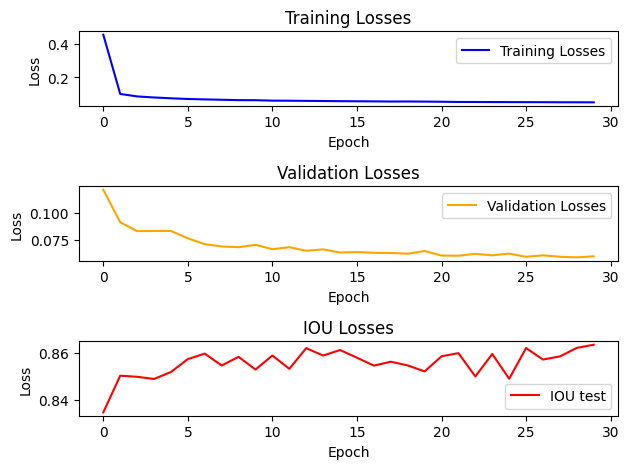

In [62]:
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(iou_test, label='IOU test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('IOU Losses')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

In [63]:
validation(model, train_loader)

100%|██████████| 207/207 [00:18<00:00, 11.15it/s]


KeyboardInterrupt: 

In [85]:
validation(model, test_loader)

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


IOU: 0.8633340799925302
Precision: 0.9388420309822239, Recall: 0.9985524970507275
